In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode
import math
%matplotlib inline


In [2]:
matches = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')
match_ids = matches[matches.season >= 2016]['id'].unique()
matches1 = matches[(matches.season >= 2016) & (matches['result']=='normal')]
matches1 = matches1.drop(['player_of_match','venue','umpire1','umpire2','umpire3', 'dl_applied', 'city', 'date', 'result'], axis=1)
matches1.dropna(inplace=True)

In [3]:
def team_correction(row):
    row = row.strip()
    if row == 'Delhi Daredevils':
        return 'Delhi Capitals'
    if row == 'Rising Pune Supergiants':
        return 'Rising Pune Supergiant'
    return row

for col in ['team1', 'team2', 'winner', 'toss_winner']:
    matches1[col] = matches1[col].apply(team_correction)
    

In [6]:
team_1 = 'Delhi Capitals'
team_2 = 'Sunrisers Hyderabad'

In [4]:
delivery = delivery[delivery.match_id.apply(lambda x: True if x in match_ids else False)]
for col in ['batting_team', 'bowling_team']:
    delivery[col] = delivery[col].apply(team_correction)

delivery.fillna(0, inplace=True)
delivery['player_dismissed'] = delivery['player_dismissed'].apply(lambda x: 0 if x==0 else 1)

delivery['batsman_runs'] = delivery['batsman_runs'].apply(lambda x: x-1 if ((x==7) or (x==5)) else x)

In [5]:
def clean(row):
    if row['extra_runs']>= row['batsman_runs']:
        row['extra_runs'] -= row['batsman_runs']
        
    return row

delivery = delivery.apply(clean, axis=1)
delivery['total_runs'] = delivery['extra_runs'] + delivery['batsman_runs']

# Winning Probability of Teams

Text(0.5, 1.0, 'DC Total Runs Score Stats Per Count')

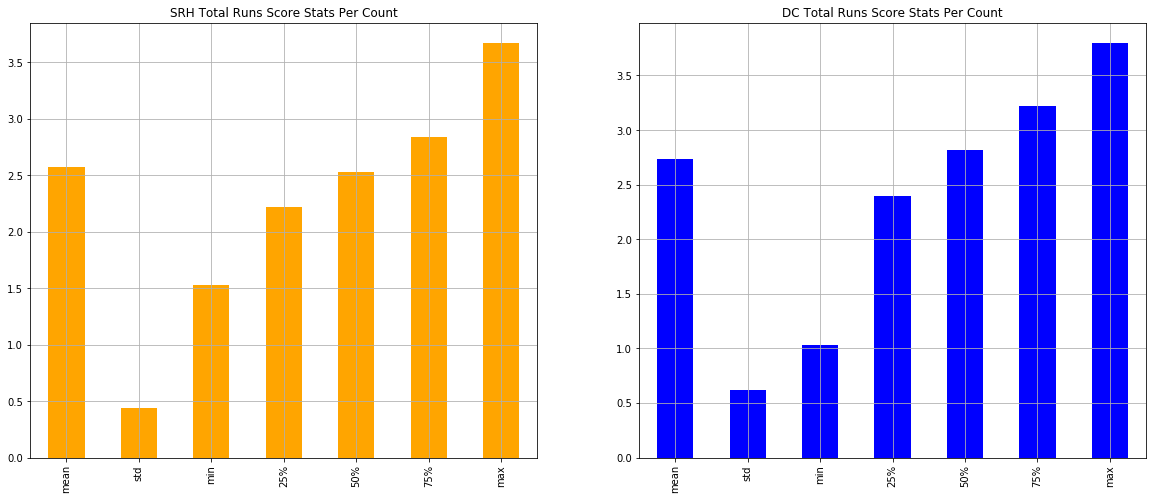

In [7]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
srh_runs = delivery[delivery['batting_team']==team_2].groupby('match_id').sum()['total_runs']
dc_runs = delivery[delivery['batting_team']==team_1].groupby('match_id').sum()['total_runs']
(srh_runs.describe()[1:]/srh_runs.describe()[0]).plot(ax=ax[0], kind='bar', grid=True, color='orange')
(dc_runs.describe()[1:]/dc_runs.describe()[0]).plot(ax=ax[1], kind='bar', grid=True, color='blue')
ax[0].set_title("SRH Total Runs Score Stats Per Count")
ax[1].set_title("DC Total Runs Score Stats Per Count")

Text(0.5, 1.0, 'Percentage of Winning')

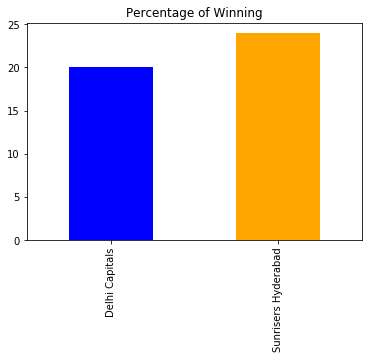

In [12]:
matches1[matches1['season']>=2017]['winner'].value_counts()[[team_1, team_2]].plot(kind='bar', color=['blue', 'orange'])
plt.title('Percentage of Winning')

# Balls to Runs

In [20]:
def balls_to_runs(team):
    team_20 = list()
    for match_id in delivery[(delivery['batting_team']==team)]['match_id'].unique():
        balls_30, balls_20 = 0, 0
        runs_30 = 0
        for run in delivery[(delivery['batting_team']==team) & (delivery['match_id']==match_id)]['total_runs']:
            balls_30 += 1
            runs_30 += run

            if runs_30 in range(30, 36):
                break

        runs_20 = runs_30
        for run in delivery[(delivery['batting_team']==team) & (delivery['match_id']==match_id)]['total_runs'][balls_30:]:
            balls_20 += 1
            runs_20 += run

            if runs_20>=(runs_30+20):
                break
        team_20.append([match_id, runs_30, balls_30, runs_20, balls_20])   

    team_20_df = pd.DataFrame(data=team_20, columns=['match_id', '30 Runs', 'Balls to 30 Runs', '20 more Runs', 'Balls to 20 Runs'])
    print(team_20_df['Balls to 20 Runs'].describe())
    team_20_df['Balls to 20 Runs'].hist()
    plt.xticks([10, 15, 20, 25, 30, 35, 40])
    plt.title("Histogram of Balls to score more 20 runs by {}".format(team))

count    58.000000
mean     16.155172
std       5.812273
min       7.000000
25%      12.000000
50%      15.000000
75%      20.750000
max      35.000000
Name: Balls to 20 Runs, dtype: float64


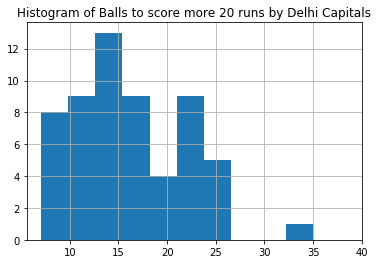

In [21]:
balls_to_runs(team_1)

count    63.000000
mean     16.079365
std       6.312562
min       5.000000
25%      11.500000
50%      15.000000
75%      19.000000
max      32.000000
Name: Balls to 20 Runs, dtype: float64


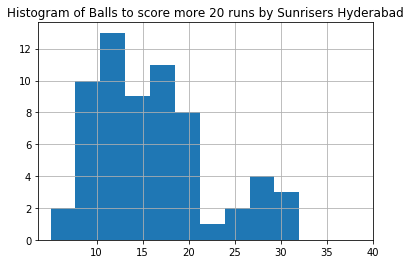

In [22]:
balls_to_runs(team_2)

# David Runs Score in Last 7 balls

In [82]:
def runs_in_last_balls(batsman):
    runs = list()
    for match_id in delivery[(delivery['batsman']==batsman)]['match_id'].unique():
        match = delivery[(delivery['batsman']==batsman) & (delivery['match_id']==match_id)]
        runs.append(sum(match['batsman_runs'][-7:]))
    runs_df = pd.DataFrame({'Runs': runs})
    runs_df['Runs'].hist(color='black')
    print(runs_df['Runs'].describe()) 

count    43.000000
mean     10.093023
std       5.286163
min       0.000000
25%       6.500000
50%       9.000000
75%      13.500000
max      23.000000
Name: Runs, dtype: float64


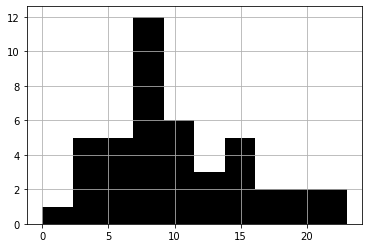

In [83]:
runs_in_last_balls('DA Warner')

# Boundaries Count

In [52]:
def boundaries_count(batsman):
    boundary = list()
    for match_id in delivery[(delivery['batsman']==batsman)]['match_id'].unique():
        match = delivery[(delivery['batsman']==batsman) & (delivery['match_id']==match_id) & (delivery['batsman_runs'].isin([4, 6]))]
        if len(match)>0:
            boundary.append(len(match))
    if len(boundary)!=0:    
        return np.mean(boundary)

In [53]:
srh_team = ['DA Warner', 'J Bairstow', 'WP Saha', 'MK Pandey', 'KS Williamson', 'Rashid Khan', 'K Ahmed', 'T Natarajan']
dc_team = ['P Shaw', 'S Dhawan', 'SS Iyer', 'RR Pant', 'S Hetmyer', 'MP Stoinis', 'AR Patel', 'R Ashwin', 'HV Patel', 'K Rabada']
teams = srh_team + dc_team

In [68]:
mean_boundaries = list()
for batsman in teams:
    mean_boundaries.append([batsman, boundaries_count(batsman)])

batsman_boundaries = pd.DataFrame(mean_boundaries, columns=['Batsman', 'Mean Boundaries'])
batsman_boundaries.sort_values('Mean Boundaries', ascending=False, inplace=True)
batsman_boundaries['Team Color'] = batsman_boundaries['Batsman'].apply(lambda x: 'orange' if x in srh_team else 'blue')

Text(0.5, 1.0, 'Batsman Mean Boundaries Per Match')

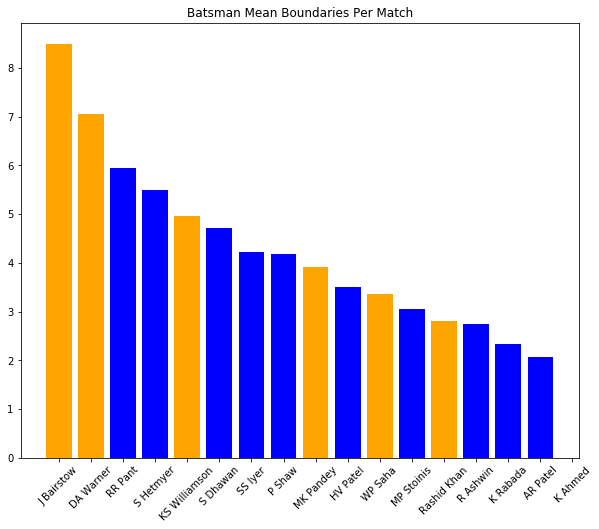

In [81]:
plt.figure(figsize=(10,8))
plt.bar(x=batsman_boundaries['Batsman'], height = batsman_boundaries['Mean Boundaries'], color=batsman_boundaries['Team Color'])
plt.xticks(rotation=45)
plt.title("Batsman Mean Boundaries Per Match")

# Rashid Khan number of wickets

In [79]:
def wickets_by_bowler(bowler):
    wicket = list()
    for match_id in delivery[(delivery['bowler']==bowler)]['match_id'].unique():
        match =  delivery[(delivery['bowler']==bowler) & (delivery['match_id']==match_id) & (delivery['player_dismissed']==1)]
        wicket.append(len(match))
    
    pct_wicket_chances = len(delivery[(delivery['bowler']==bowler) & (delivery['player_dismissed']==1)]['match_id'].unique()) / len(delivery[(delivery['bowler']==bowler)]['match_id'].unique()) 
    
    return (np.median(wicket), f"{round(pct_wicket_chances*100)}%")


In [80]:
wickets_by_bowler('Rashid Khan')

(1.0, '83%')

# Summary

1. Using winner column and comparing central tendency measures of total scores per match for both teams, winning chances were calculated.
2. Function was created which counts no. of balls to score 30, and then 20 more, using total_runs column and then histogram peak of both teams was subtracted to find the range of difference.
3. Function was created to calculate batsman runs per match using batsman runs column and taking only last 7 balls he played and then taking histogram peak to estimate range. 
4. Boundaries counting per batsman was done using a function which filters those deliveries where batsman runs has 4 or 6 and then using len, finds the count of deliveries per match and mean boundaries was calculated. Plotting those mean values, the batsman was decided. 
5. Wickets per match by bowler was calculated using player_dismissed column. Median values were taken for all his matches. Percentage dismissal chances were calculated using matches with wickets and total matches ratio. 